This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Load ODIM_H5 Volume data from German Weather Service

In this example, we obtain and read the latest 30 minutes of available volumetric radar data from German Weather Service available at [opendata.dwd.de](https://opendata.dwd.de). Finally we do some plotting.

This retrieves 6 timesteps of the 10 sweeps (moments DBZH and VRADH) of the DWD volume scan of a distinct radar. This amounts to 120 data files which are combined into one volumetric Cf/Radial2 like xarray powered structure.

Exports to single file Odim_H5 and Cf/Radial2 format are shown at the end of this tutorial.

<div class="alert alert-warning">

**Note** <br>

The used `open_odim_mfdataset` implementation is based on [xarray](https://xarray.pydata.org). It claims multiple data files and presents them in a simple structure. See also the notebook [wradlib_odim_backend](wradlib_odim_backend.ipynb) for further details.

</div>

In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
from wradlib.io import open_odim_mfdataset

In [2]:
import urllib3
import os
import io
import glob
import shutil
import datetime

## Download radar volumes of latest 30 minutes from server using `wetterdienst`


`wetterdienst` is a neat package for easy retrieval of data primarily from DWD. For further information have a look at their [documentation](https://wetterdienst.readthedocs.io/).

In [3]:
from wetterdienst.provider.dwd.radar import DwdRadarDataFormat, DwdRadarDataSubset, DwdRadarParameter, DwdRadarValues
from wetterdienst.provider.dwd.radar.sites import DwdRadarSite

In [4]:
elevations = range(10)

end_date = datetime.datetime.utcnow()
start_date = end_date - datetime.timedelta(minutes=30)

results_velocity = []
results_reflectivity = []

for el in elevations:
    # Horizontal Doppler Velocity
    request_velocity = DwdRadarValues(
        parameter=DwdRadarParameter.SWEEP_VOL_VELOCITY_H,
        start_date=start_date,
        end_date=end_date,
        site=DwdRadarSite.ESS,
        elevation=el,
        fmt=DwdRadarDataFormat.HDF5,
        subset=DwdRadarDataSubset.POLARIMETRIC,
    )

    # Horizontal Reflectivity
    request_reflectivity = DwdRadarValues(
        parameter=DwdRadarParameter.SWEEP_VOL_REFLECTIVITY_H,
        start_date=start_date,
        end_date=end_date,
        elevation=el,
        site=DwdRadarSite.ESS,fmt=DwdRadarDataFormat.HDF5,
        subset=DwdRadarDataSubset.POLARIMETRIC,
    )

    # Submit requests.
    results_velocity.append(request_velocity.query())
    results_reflectivity.append(request_reflectivity.query())

## Acquire data as memory buffer

In [5]:
%%time
volume_velocity = []
for item1 in results_velocity:
    files = []
    for item2 in item1:
        files.append(item2.data)
    volume_velocity.append(files)

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 1/240 [00:03<15:32,  3.90s/it]

  1%|          | 2/240 [00:04<06:58,  1.76s/it]

  1%|▏         | 3/240 [00:04<04:20,  1.10s/it]

  2%|▏         | 4/240 [00:04<02:56,  1.34it/s]

  2%|▏         | 5/240 [00:04<02:10,  1.80it/s]

  2%|▎         | 6/240 [00:05<01:42,  2.28it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  2%|▎         | 6/240 [00:05<03:42,  1.05it/s]

  0%|          | 1/240 [00:01<04:55,  1.24s/it]

  1%|          | 2/240 [00:01<02:31,  1.57it/s]

  1%|▏         | 3/240 [00:01<01:59,  1.98it/s]

  2%|▏         | 4/240 [00:02<01:32,  2.56it/s]

  2%|▏         | 5/240 [00:02<01:16,  3.06it/s]

  2%|▎         | 6/240 [00:02<01:07,  3.46it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 1/240 [00:01<04:12,  1.06s/it]

  1%|          | 2/240 [00:01<02:13,  1.78it/s]

  1%|▏         | 3/240 [00:01<01:35,  2.48it/s]

  2%|▏         | 4/240 [00:01<01:17,  3.04it/s]

  2%|▏         | 5/240 [00:01<01:07,  3.48it/s]

  2%|▎         | 6/240 [00:02<01:01,  3.81it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  2%|▎         | 6/240 [00:05<03:16,  1.19it/s]


  2%|▎         | 6/240 [00:02<01:40,  2.33it/s]

  0%|          | 1/240 [00:01<04:30,  1.13s/it]

  1%|          | 2/240 [00:01<02:21,  1.68it/s]

  1%|▏         | 3/240 [00:01<01:40,  2.36it/s]

  2%|▏         | 4/240 [00:01<01:21,  2.91it/s]

  2%|▏         | 5/240 [00:02<01:10,  3.34it/s]

  2%|▎         | 6/240 [00:02<01:03,  3.67it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 1/240 [00:00<03:58,  1.00it/s]

  1%|          | 2/240 [00:01<02:09,  1.84it/s]

  1%|▏         | 3/240 [00:01<01:34,  2.52it/s]

  2%|▏         | 4/240 [00:01<01:17,  3.04it/s]

  2%|▏         | 5/240 [00:01<01:08,  3.42it/s]

  2%|▎         | 6/240 [00:02<01:03,  3.70it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  2%|▎         | 6/240 [00:04<03:10,  1.23it/s]


  2%|▎         | 6/240 [00:02<01:43,  2.27it/s]

  0%|          | 1/240 [00:01<04:53,  1.23s/it]

  1%|          | 2/240 [00:01<02:48,  1.41it/s]

  1%|▏         | 3/240 [00:01<01:55,  2.04it/s]

  2%|▏         | 4/240 [00:02<01:31,  2.59it/s]

  2%|▏         | 5/240 [00:02<01:17,  3.05it/s]

  2%|▎         | 6/240 [00:02<01:08,  3.41it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 1/240 [00:01<04:18,  1.08s/it]

  1%|          | 2/240 [00:01<02:15,  1.76it/s]

  1%|▏         | 3/240 [00:01<01:35,  2.48it/s]

  2%|▎         | 6/240 [00:04<02:38,  1.47it/s]

  2%|▏         | 4/240 [00:01<01:26,  2.73it/s]

  2%|▏         | 5/240 [00:02<01:21,  2.90it/s]

  2%|▎         | 6/240 [00:02<01:18,  2.99it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 1/240 [00:01<04:12,  1.06s/it]

  1%|          | 2/240 [00:01<02:25,  1.64it/s]

  1%|▏         | 3/240 [00:01<01:51,  2.13it/s]

  2%|▏         | 4/240 [00:01<01:34,  2.49it/s]

  2%|▏         | 5/240 [00:02<01:25,  2.74it/s]

  2%|▎         | 6/240 [00:02<01:23,  2.79it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  2%|▎         | 6/240 [00:05<03:35,  1.08it/s]


  2%|▎         | 6/240 [00:03<02:00,  1.94it/s]

  0%|          | 1/240 [00:01<04:39,  1.17s/it]

  1%|          | 2/240 [00:01<02:36,  1.52it/s]

  1%|▏         | 3/240 [00:01<01:57,  2.01it/s]

  2%|▏         | 4/240 [00:02<01:39,  2.38it/s]

  2%|▏         | 5/240 [00:02<01:43,  2.27it/s]

  2%|▎         | 6/240 [00:02<01:36,  2.43it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 1/240 [00:01<04:22,  1.10s/it]

  1%|          | 2/240 [00:01<02:36,  1.52it/s]

  1%|▏         | 3/240 [00:01<02:02,  1.94it/s]

  2%|▏         | 4/240 [00:02<01:46,  2.22it/s]

  2%|▏         | 5/240 [00:02<01:37,  2.42it/s]

  2%|▎         | 6/240 [00:02<01:31,  2.56it/s]

CPU times: user 6.41 s, sys: 166 ms, total: 6.58 s
Wall time: 27.4 s


In [6]:
%%time
volume_reflectivity = []
for item1 in results_reflectivity:
    files = []
    for item2 in item1:
        files.append(item2.data)
    volume_reflectivity.append(files)

  0%|          | 0/240 [00:00<?, ?it/s]

  2%|▎         | 6/240 [00:06<04:03,  1.04s/it]


  2%|▎         | 6/240 [00:03<02:10,  1.80it/s]

  0%|          | 1/240 [00:01<05:15,  1.32s/it]

  1%|          | 2/240 [00:01<03:04,  1.29it/s]

  1%|▏         | 3/240 [00:02<02:20,  1.68it/s]

  2%|▏         | 4/240 [00:02<01:59,  1.97it/s]

  2%|▏         | 5/240 [00:02<01:47,  2.18it/s]

  2%|▎         | 6/240 [00:03<01:38,  2.37it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 1/240 [00:01<04:57,  1.24s/it]

  1%|          | 2/240 [00:01<02:52,  1.38it/s]

  1%|▏         | 3/240 [00:01<02:12,  1.79it/s]

  2%|▏         | 4/240 [00:02<02:05,  1.88it/s]

  2%|▏         | 5/240 [00:02<02:00,  1.94it/s]

  2%|▎         | 6/240 [00:03<01:51,  2.10it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  2%|▎         | 6/240 [00:07<04:35,  1.18s/it]


  2%|▎         | 6/240 [00:03<02:30,  1.55it/s]

  0%|          | 1/240 [00:01<05:24,  1.36s/it]

  1%|          | 2/240 [00:01<03:05,  1.28it/s]

  1%|▏         | 3/240 [00:02<02:23,  1.65it/s]

  2%|▏         | 4/240 [00:02<02:01,  1.94it/s]

  2%|▏         | 5/240 [00:02<01:48,  2.16it/s]

  2%|▎         | 6/240 [00:03<01:41,  2.31it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  2%|▎         | 6/240 [00:04<02:39,  1.46it/s]

  0%|          | 1/240 [00:01<04:54,  1.23s/it]

  1%|          | 2/240 [00:01<02:51,  1.38it/s]

  1%|▏         | 3/240 [00:01<02:11,  1.80it/s]

  2%|▏         | 4/240 [00:02<01:53,  2.08it/s]

  2%|▏         | 5/240 [00:02<01:42,  2.29it/s]

  2%|▎         | 6/240 [00:03<01:35,  2.44it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 1/240 [00:01<05:09,  1.30s/it]

  1%|          | 2/240 [00:01<03:00,  1.32it/s]

  1%|▏         | 3/240 [00:02<02:16,  1.73it/s]

  2%|▏         | 4/240 [00:02<01:56,  2.03it/s]

  2%|▏         | 5/240 [00:02<01:43,  2.26it/s]

  2%|▎         | 6/240 [00:03<01:36,  2.43it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  2%|▎         | 6/240 [00:06<04:19,  1.11s/it]


  2%|▎         | 6/240 [00:03<02:20,  1.67it/s]

  0%|          | 1/240 [00:01<04:54,  1.23s/it]

  1%|          | 2/240 [00:01<02:48,  1.41it/s]

  1%|▏         | 3/240 [00:01<02:08,  1.85it/s]

  2%|▏         | 4/240 [00:02<01:49,  2.16it/s]

  2%|▏         | 5/240 [00:02<01:38,  2.39it/s]

  2%|▎         | 6/240 [00:02<01:33,  2.49it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 1/240 [00:01<04:05,  1.03s/it]

  1%|          | 2/240 [00:01<02:18,  1.72it/s]

  1%|▏         | 3/240 [00:01<01:43,  2.28it/s]

  2%|▏         | 4/240 [00:01<01:27,  2.69it/s]

  2%|▏         | 5/240 [00:02<02:24,  1.62it/s]

  2%|▎         | 6/240 [00:03<01:56,  2.02it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  2%|▎         | 6/240 [00:06<04:19,  1.11s/it]


  2%|▎         | 6/240 [00:03<02:23,  1.63it/s]

  0%|          | 1/240 [00:01<04:52,  1.22s/it]

  1%|          | 2/240 [00:01<02:33,  1.55it/s]

  1%|▏         | 3/240 [00:01<01:48,  2.18it/s]

  2%|▏         | 4/240 [00:01<01:27,  2.70it/s]

  2%|▏         | 5/240 [00:02<01:28,  2.67it/s]

  2%|▎         | 6/240 [00:02<01:16,  3.05it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  2%|▎         | 6/240 [00:03<02:04,  1.88it/s]

  0%|          | 1/240 [00:01<04:47,  1.20s/it]

  1%|          | 2/240 [00:01<02:31,  1.57it/s]

  1%|▏         | 3/240 [00:01<01:47,  2.21it/s]

  2%|▏         | 4/240 [00:01<01:26,  2.73it/s]

  2%|▏         | 5/240 [00:02<01:14,  3.14it/s]

  2%|▎         | 6/240 [00:02<01:16,  3.07it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 1/240 [00:01<04:29,  1.13s/it]

  1%|          | 2/240 [00:01<02:22,  1.66it/s]

  1%|▏         | 3/240 [00:01<01:42,  2.31it/s]

  2%|▏         | 4/240 [00:01<01:23,  2.83it/s]

  2%|▏         | 5/240 [00:02<01:13,  3.21it/s]

  2%|▎         | 6/240 [00:02<01:06,  3.51it/s]

CPU times: user 6.67 s, sys: 192 ms, total: 6.87 s
Wall time: 29.5 s


## Read the data into xarray powered structure

In [7]:
vol = wrl.io.RadarVolume()
for r, v in zip(volume_reflectivity, volume_velocity):
    ds0 = wrl.io.open_odim_mfdataset(r, group="dataset1", 
                                     concat_dim="time", 
                                     combine="nested",
                                    )
    ds1 = wrl.io.open_odim_mfdataset(v, group="dataset1", 
                                     concat_dim="time", 
                                     combine="nested",
                                    )
    
    vol.append(xr.merge([ds0, ds1], combine_attrs="override"))
    vol.sort(key=lambda x: x.time.min().values)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

100%|██████████| 1/1 [00:00<00:00,  6.10it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

## Inspect structure
### Root Group

In [8]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 10)
Coordinates:
    sweep_mode           <U20 'azimuth_surveillance'
    longitude            float64 6.967
    altitude             float64 185.1
    latitude             float64 51.41
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2021-06-01T09:30:35Z'
    time_coverage_end    <U20 '2021-06-01T09:59:02Z'
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_8' 'sweep_9'
    sweep_fixed_angle    (sweep) float64 5.5 4.5 3.5 2.5 ... 8.0 12.0 17.0 25.0
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      5.5

In [9]:
vol.root.sweep_fixed_angle

<xarray.DataArray 'sweep_fixed_angle' (sweep: 10)>
array([ 5.5,  4.5,  3.5,  2.5,  1.5,  0.5,  8. , 12. , 17. , 25. ])
Coordinates:
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 6.967
    altitude    float64 185.1
    latitude    float64 51.41
Dimensions without coordinates: sweep

### Sweep Groups

In [10]:
vol

<wradlib.RadarVolume>
Dimension(s): (sweep: 10)
Elevation(s): (5.5, 4.5, 3.5, 2.5, 1.5, 0.5, 8.0, 12.0, 17.0, 25.0)

In [11]:
vol[0]

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 720, time: 6)
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    rtime       (time, azimuth) datetime64[ns] dask.array<chunksize=(1, 360), meta=np.ndarray>
  * range       (range) float32 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
  * time        (time) datetime64[ns] 2021-06-01T09:30:35 ... 2021-06-01T09:5...
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 6.967
    latitude    float64 51.41
    altitude    float64 185.1
Data variables:
    DBZH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    VRADH       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    fixed_angle:  5.5

## plot sweeps
### DBZH

  2%|▎         | 6/240 [00:10<06:43,  1.73s/it]


  2%|▎         | 6/240 [00:07<05:06,  1.31s/it]

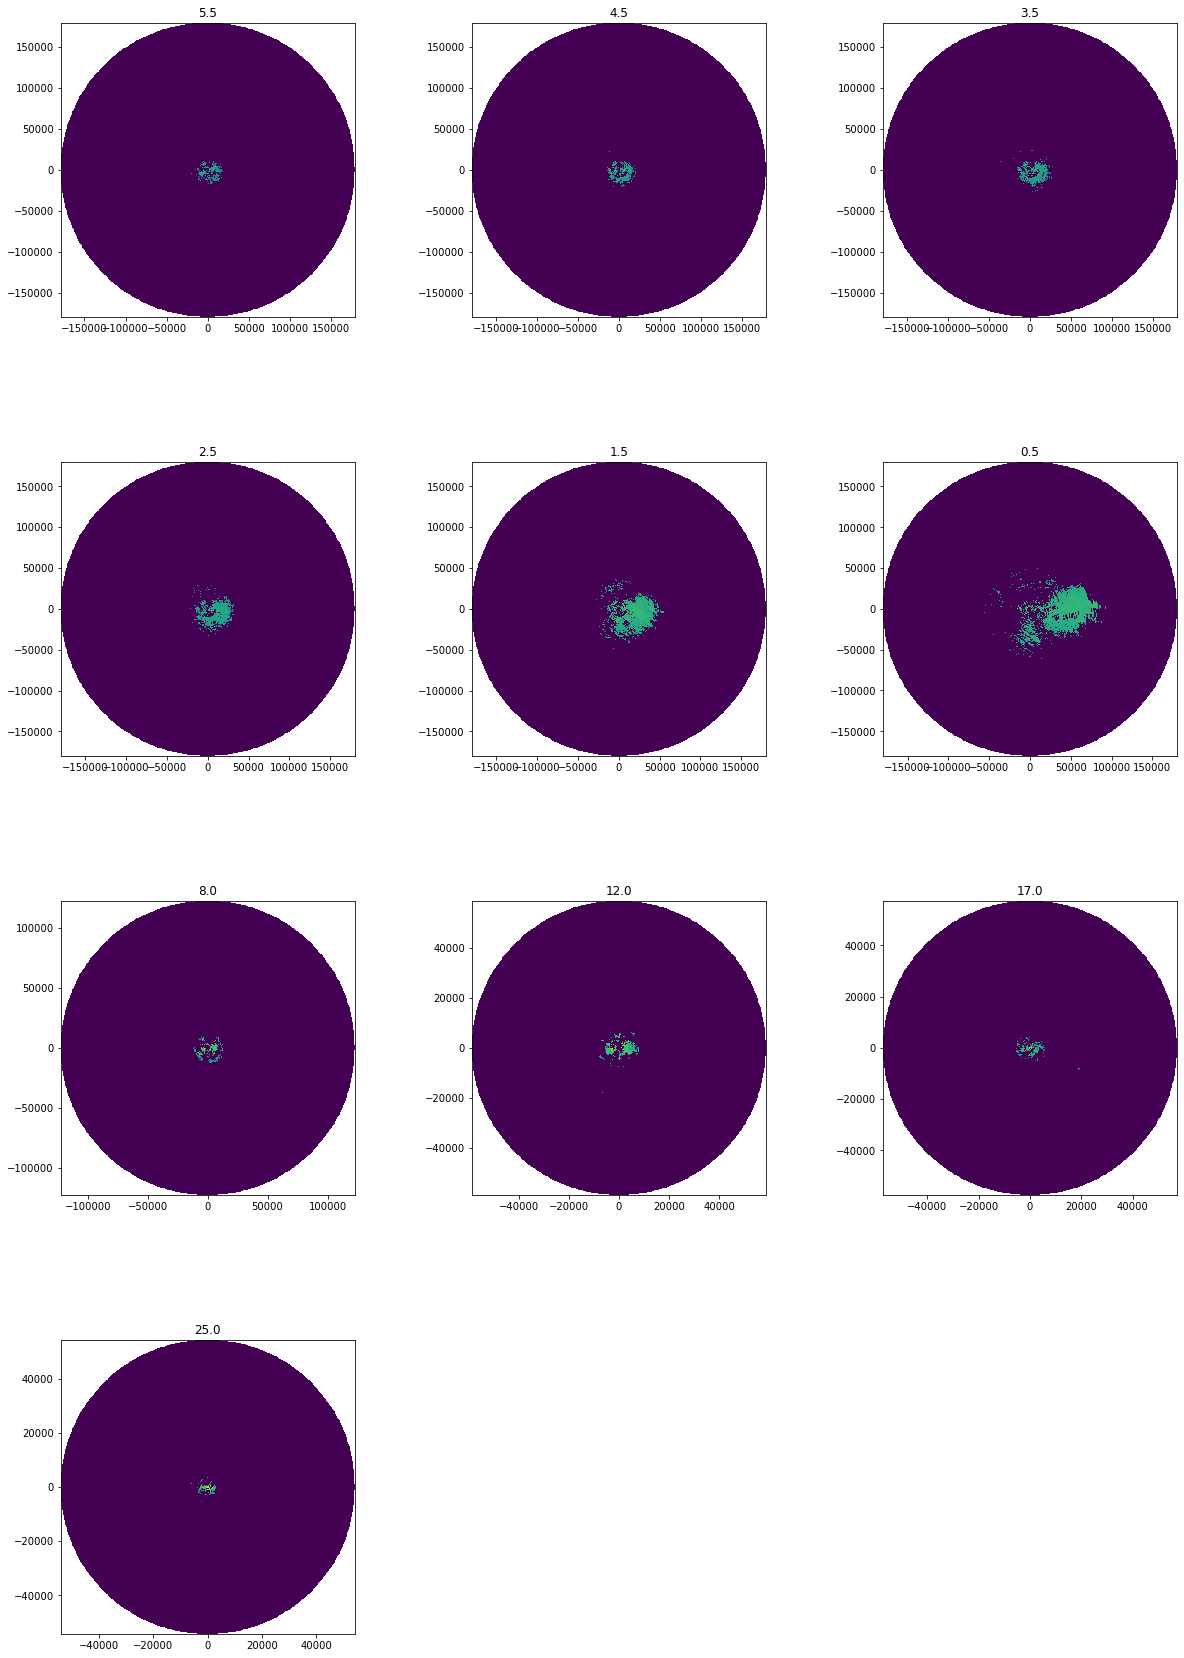

In [12]:
fig = pl.figure(figsize=(20, 30))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 3, wspace=0.4, hspace=0.4)
for i, ts in enumerate(vol):
    swp = ts.isel(time=0)
    swp.DBZH.pipe(wrl.georef.georeference_dataset).wradlib.plot(ax=gs[i], fig=fig)
    ax = pl.gca()
    ax.set_title(vol.root.sweep_fixed_angle[i].values)

### VRADH

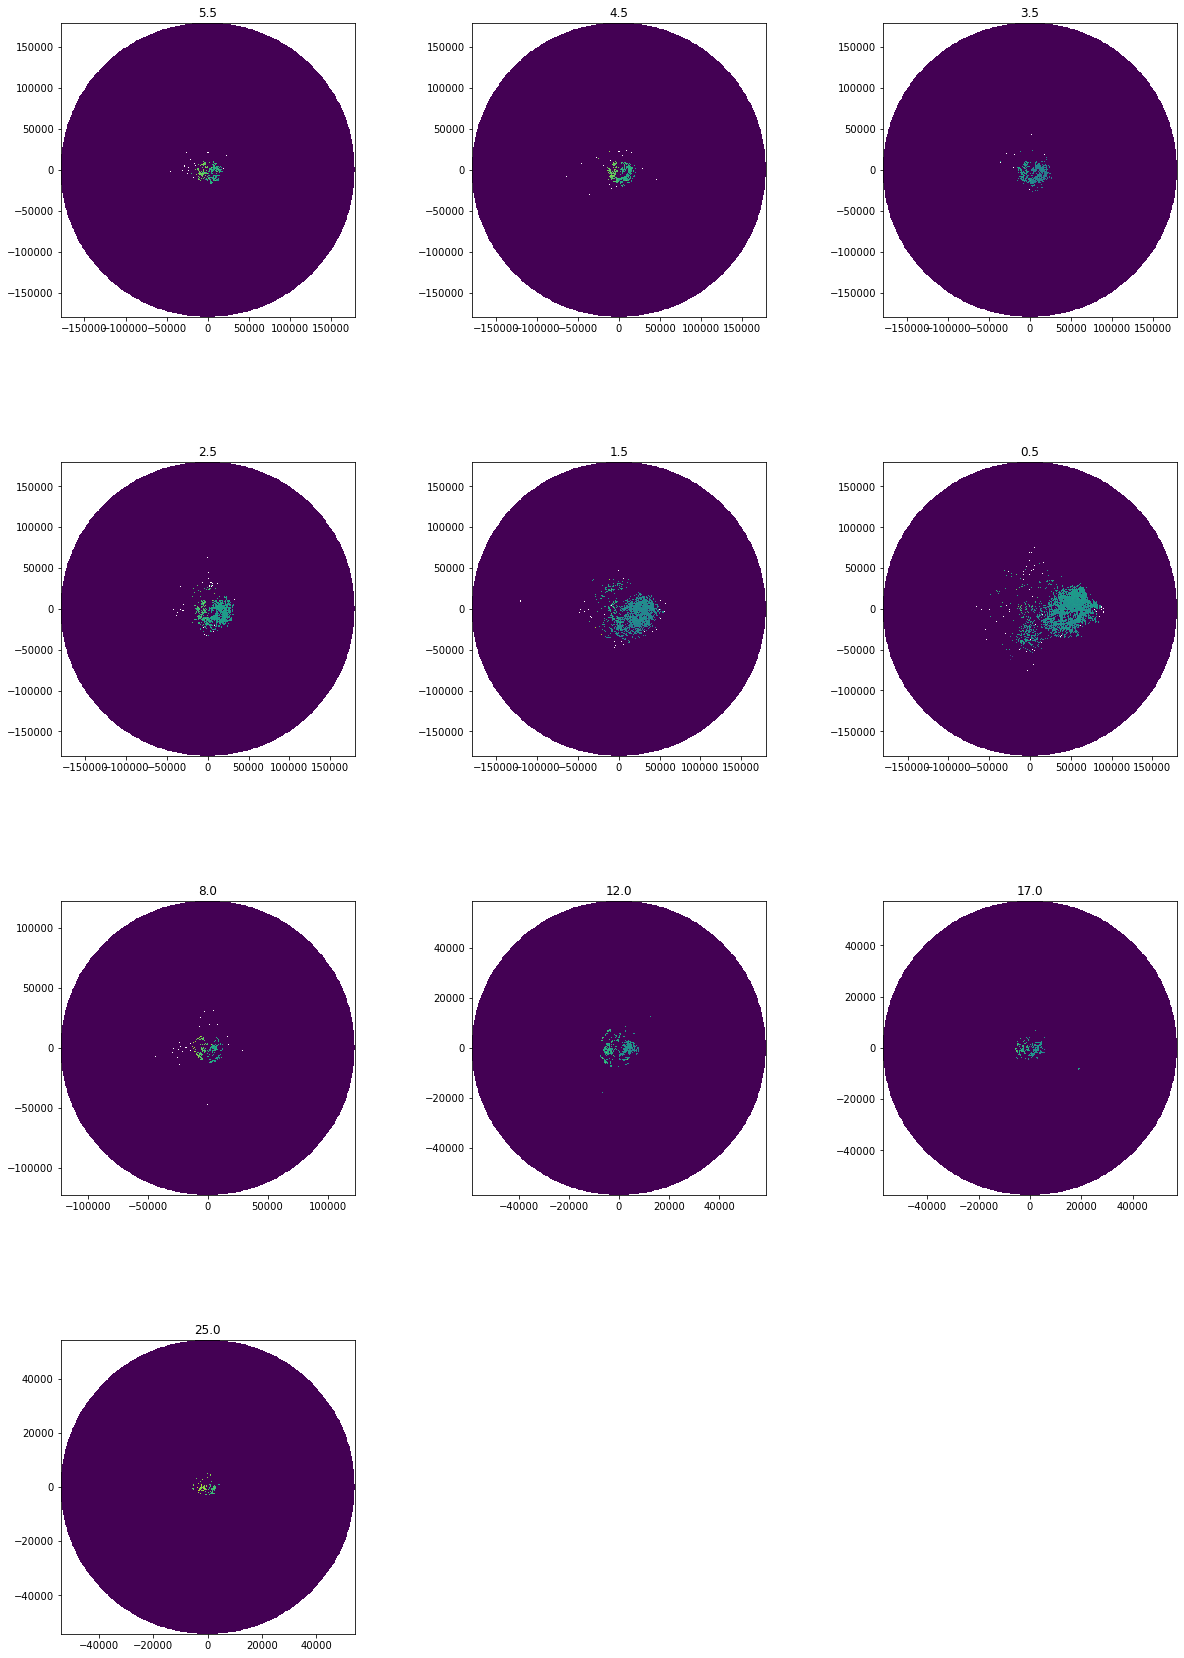

In [13]:
fig = pl.figure(figsize=(20, 30))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 3, wspace=0.4, hspace=0.4)
for i, ts in enumerate(vol):
    swp = ts.isel(time=0)
    swp.VRADH.pipe(wrl.georef.georeference_dataset).wradlib.plot(ax=gs[i], fig=fig)
    ax = pl.gca()
    ax.set_title(vol.root.sweep_fixed_angle[i].values)

### Plot single sweep using cartopy

In [14]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(central_latitude=vol.root.latitude.values, 
                                      central_longitude=vol.root.longitude.values)

In [15]:
vol[-1]

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 240, time: 6)
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    rtime       (time, azimuth) datetime64[ns] dask.array<chunksize=(1, 360), meta=np.ndarray>
  * range       (range) float32 125.0 375.0 625.0 ... 5.962e+04 5.988e+04
  * time        (time) datetime64[ns] 2021-06-01T09:33:50 ... 2021-06-01T09:5...
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 6.967
    latitude    float64 51.41
    altitude    float64 185.1
Data variables:
    DBZH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 240), meta=np.ndarray>
    VRADH       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 240), meta=np.ndarray>
Attributes:
    fixed_angle:  25.0

< GeoAxes: <cartopy.crs.AzimuthalEquidistant object at 0x7f361a6e7680> >


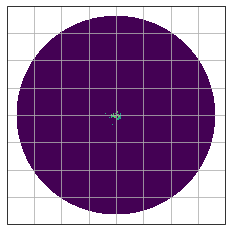

In [16]:
map_proj = ccrs.AzimuthalEquidistant(central_latitude=vol.root.latitude.values, 
                                      central_longitude=vol.root.longitude.values)
pm = vol[-1].isel(time=0).DBZH.pipe(wrl.georef.georeference_dataset).wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

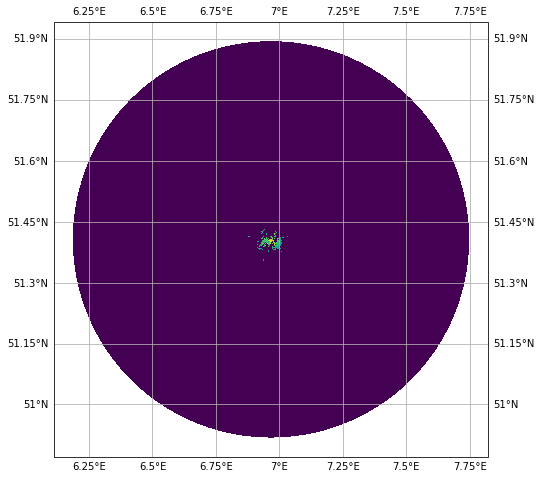

In [17]:
map_proj = ccrs.Mercator(central_longitude=vol.root.longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
pm = vol[-1].isel(time=0).DBZH.pipe(wrl.georef.georeference_dataset).wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

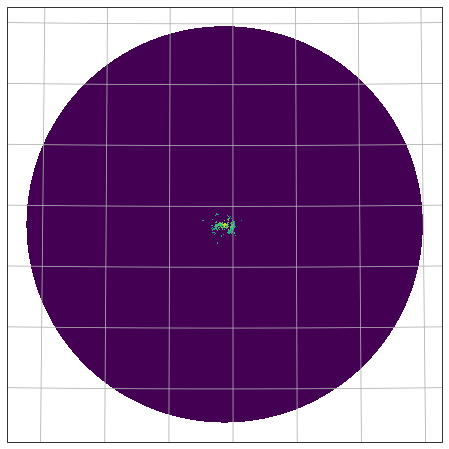

In [18]:
fig = pl.figure(figsize=(10, 8))
proj=ccrs.AzimuthalEquidistant(central_latitude=vol.root.latitude.values, 
                               central_longitude=vol.root.longitude.values)
ax = fig.add_subplot(111, projection=proj)
pm = vol[-1].isel(time=0).DBZH.pipe(wrl.georef.georeference_dataset).wradlib.plot_ppi(ax=ax)
ax.gridlines()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray inherits dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial and/or ODIM_H5 standard.

In [19]:
vol[-1].isel(time=0).DBZH

<xarray.DataArray 'DBZH' (azimuth: 360, range: 240)>
dask.array<getitem, shape=(360, 240), dtype=float32, chunksize=(360, 240), chunktype=numpy.ndarray>
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    rtime       (azimuth) datetime64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
  * range       (range) float32 125.0 375.0 625.0 ... 5.962e+04 5.988e+04
    time        datetime64[ns] 2021-06-01T09:33:50
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 6.967
    latitude    float64 51.41
    altitude    float64 185.1
Attributes:
    _Undetect:      0.0
    long_name:      Equivalent reflectivity factor H
    units:          dBZ
    standard_name:  radar_equivalent_reflectivity_factor_h

In [20]:
vol[-1].isel(time=0).sweep_mode

<xarray.DataArray 'sweep_mode' ()>
array('azimuth_surveillance', dtype='<U20')
Coordinates:
    time        datetime64[ns] 2021-06-01T09:33:50
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 6.967
    latitude    float64 51.41
    altitude    float64 185.1

In [21]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 10)
Coordinates:
    sweep_mode           <U20 'azimuth_surveillance'
    longitude            float64 6.967
    altitude             float64 185.1
    latitude             float64 51.41
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2021-06-01T09:30:35Z'
    time_coverage_end    <U20 '2021-06-01T09:59:02Z'
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_8' 'sweep_9'
    sweep_fixed_angle    (sweep) float64 5.5 4.5 3.5 2.5 ... 8.0 12.0 17.0 25.0
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      5.5

## Plot Quasi Vertical Profile

In [22]:
vol

<wradlib.RadarVolume>
Dimension(s): (sweep: 10)
Elevation(s): (5.5, 4.5, 3.5, 2.5, 1.5, 0.5, 8.0, 12.0, 17.0, 25.0)

In [23]:
ts = vol[-1]
ts

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 240, time: 6)
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    elevation   (azimuth) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    rtime       (time, azimuth) datetime64[ns] dask.array<chunksize=(1, 360), meta=np.ndarray>
  * range       (range) float32 125.0 375.0 625.0 ... 5.962e+04 5.988e+04
  * time        (time) datetime64[ns] 2021-06-01T09:33:50 ... 2021-06-01T09:5...
    sweep_mode  <U20 'azimuth_surveillance'
    longitude   float64 6.967
    latitude    float64 51.41
    altitude    float64 185.1
Data variables:
    DBZH        (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 240), meta=np.ndarray>
    VRADH       (time, azimuth, range) float32 dask.array<chunksize=(1, 360, 240), meta=np.ndarray>
Attributes:
    fixed_angle:  25.0

(0.0, 20000.0)

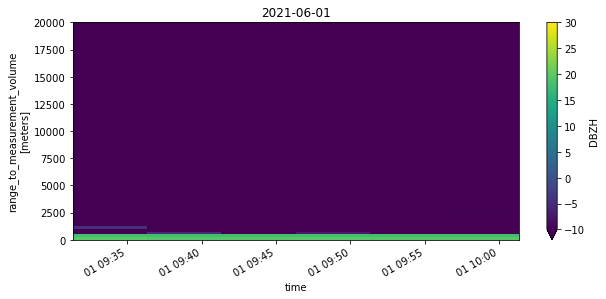

In [24]:
fig = pl.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ts.DBZH.median('azimuth').plot(x='time', vmin=-10, vmax=30, ax=ax)
ax.set_title(f"{np.datetime_as_string(ts.time[0].values, unit='D')}")
ax.set_ylim(0, 20000)

## Export to OdimH5

This exports the radar volume at given timestep including all moments into one ODIM_H5 compliant data file.

In [25]:
vol.to_odim('dwd_odim.h5', timestep=0)

## Export to Cf/Radial2

This exports the radar volume at given timestep including all moments into one Cf/Radial2 compliant data file.

In [26]:
vol.to_cfradial2('dwd_cfradial2.nc', timestep=0)

## Import again and check equality


In [27]:
vol1 = wrl.io.open_odim_dataset('dwd_odim.h5')
vol2 = wrl.io.open_cfradial2_dataset('dwd_cfradial2.nc')

In [28]:
xr.testing.assert_equal(vol1.root, vol2.root)
for i in range(len(vol1)):
    xr.testing.assert_equal(vol1[i].drop_vars("rtime"), vol2[i].drop_vars("rtime"))